# Stage 4: Extended External Validation

**Objectives**:
- Evaluate trained model on the expanded external validation dataset (24,417 images)
- Generate comprehensive metrics across all 5 classes
- Compare with original test set performance
- Analyze per-class and per-source performance

**Dataset**: `data_external_unified/` - deduplicated external images from:
- `dataset/`: 16,632 images
- `PBC_dataset_normal_DIB/`: 7,785 images

## 1. Import Libraries

In [1]:
# Add parent directory to path for imports
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

import fastai
from fastai.vision.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from tqdm.notebook import tqdm
from utils import set_seed as set_all_seeds

# Set seed for reproducibility
set_all_seeds(42)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print(f"PyTorch version: {torch.__version__}")
print(f"fastai version: {fastai.__version__}")

✓ Random seed set to 42 for reproducibility
PyTorch version: 2.9.1
fastai version: 2.8.5


## 2. Load Model

In [2]:
# Load trained model
model_path = '../outputs/model.pkl'
learn = load_learner(model_path)

print(f"✓ Model loaded from: {model_path}")
print(f"  Classes: {learn.dls.vocab}")
print(f"  Number of classes: {len(learn.dls.vocab)}")

class_names = list(learn.dls.vocab)

✓ Model loaded from: ../outputs/model.pkl
  Classes: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
  Number of classes: 5


/Users/mac/miniconda3/envs/cv/lib/python3.11/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


## 3. Load External Validation Dataset

In [3]:
# Load external manifest
manifest_path = '../outputs/external_manifest.csv'
external_df = pd.read_csv(manifest_path)

print(f"External validation dataset size: {len(external_df)}")
print(f"\nClass distribution:")
print(external_df['label'].value_counts().sort_index())
print(f"\nBy source dataset:")
print(external_df['source_dataset'].value_counts())

External validation dataset size: 24416

Class distribution:
label
basophil       1013
eosinophil     3677
lymphocyte     4323
monocyte       1714
neutrophil    13689
Name: count, dtype: int64

By source dataset:
source_dataset
dataset        16632
pbc_dataset     7784
Name: count, dtype: int64


In [4]:
# Resolve symlinks to get actual file paths
# The unified_path is relative, so we need to construct full paths
base_path = Path('..').resolve()

# Use original_path which contains absolute paths
external_df['filepath'] = external_df['original_path']

# Verify files exist
missing = external_df[~external_df['filepath'].apply(lambda x: Path(x).exists())]
if len(missing) > 0:
    print(f"Warning: {len(missing)} files not found")
else:
    print(f"✓ All {len(external_df)} files verified")

✓ All 24416 files verified


## 4. Run Inference on External Dataset

In [5]:
# Create test dataloader
# Process in batches to handle large dataset
print(f"Creating dataloader for {len(external_df)} images...")

external_dl = learn.dls.test_dl(external_df['filepath'].tolist(), bs=64)

print(f"✓ Dataloader created with {len(external_dl)} batches")

Creating dataloader for 24416 images...
✓ Dataloader created with 382 batches


In [6]:
# Get predictions
print("Generating predictions on external dataset...")
print("This may take a few minutes...")

ext_preds, _ = learn.get_preds(dl=external_dl)

print(f"✓ Predictions generated for {len(ext_preds)} images")

Generating predictions on external dataset...
This may take a few minutes...


✓ Predictions generated for 24416 images


In [9]:
# Convert to class predictions
ext_pred_classes = ext_preds.argmax(dim=1)
ext_confidences = ext_preds.max(dim=1).values

# Map string labels to indices
label_to_idx = {label: idx for idx, label in enumerate(class_names)}
ext_targets = torch.tensor([label_to_idx[label] for label in external_df['label']])

# Calculate overall accuracy
ext_accuracy = (ext_pred_classes == ext_targets).float().mean()

print("="*70)
print("EXTERNAL VALIDATION RESULTS")
print("="*70)
print(f"Total images: {len(external_df)}")
print(f"Overall Accuracy: {ext_accuracy:.4f} ({ext_accuracy*100:.2f}%)")
print(f"Correct: {(ext_pred_classes == ext_targets).sum().item()}")
print(f"Incorrect: {(ext_pred_classes != ext_targets).sum().item()}")
print("="*70)

EXTERNAL VALIDATION RESULTS
Total images: 24416
Overall Accuracy: 0.5913 (59.13%)
Correct: 14436
Incorrect: 9980


## 5. Confusion Matrix

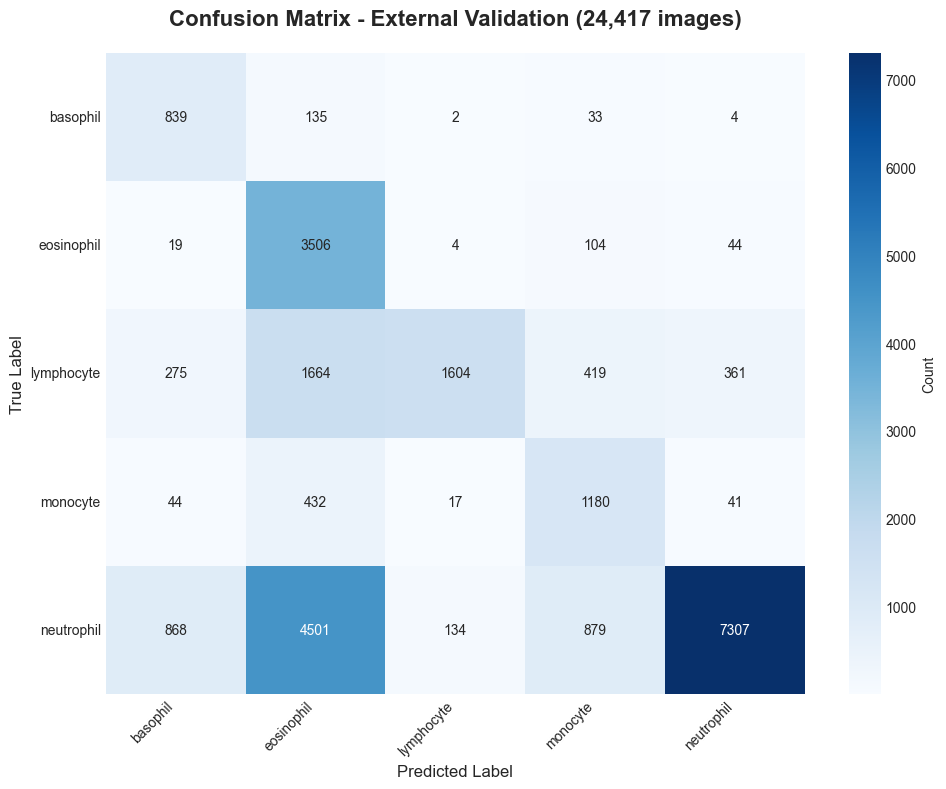

✓ Confusion matrix saved to outputs/figures/confusion_matrix_external_full.png


In [10]:
# Generate confusion matrix
cm = confusion_matrix(ext_targets.numpy(), ext_pred_classes.numpy())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - External Validation (24,417 images)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../outputs/figures/confusion_matrix_external_full.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to outputs/figures/confusion_matrix_external_full.png")

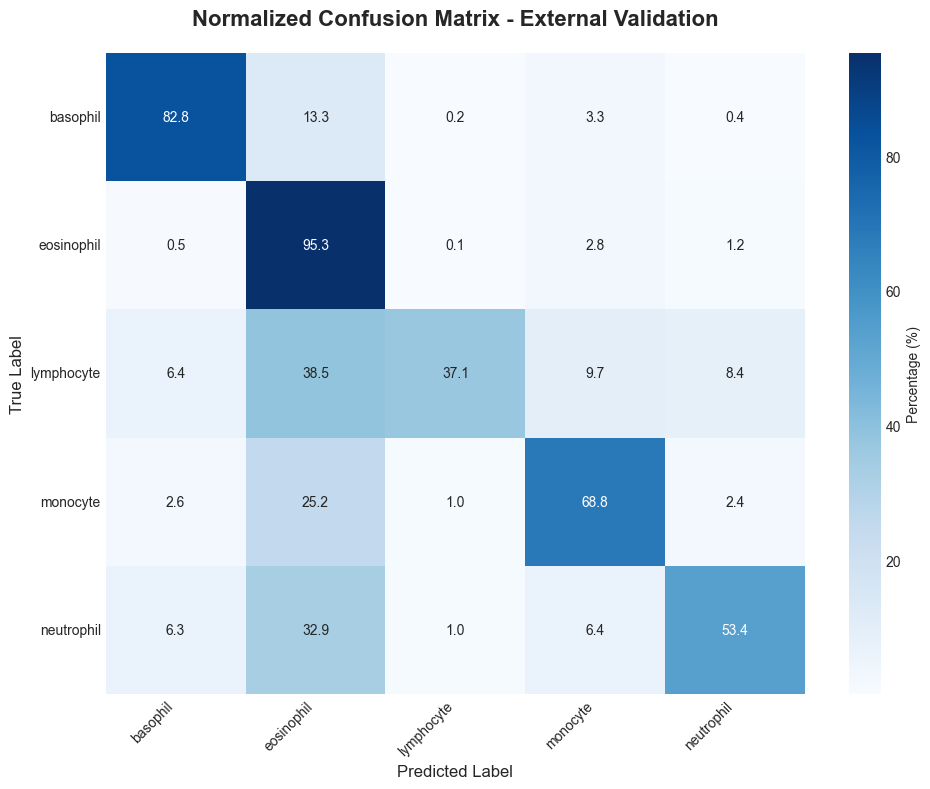

In [11]:
# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage (%)'})
plt.title('Normalized Confusion Matrix - External Validation', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../outputs/figures/confusion_matrix_external_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Classification Report

In [12]:
# Generate detailed classification report
report = classification_report(
    ext_targets.numpy(), 
    ext_pred_classes.numpy(), 
    target_names=class_names,
    digits=4
)

print("Classification Report - External Validation")
print("="*70)
print(report)

Classification Report - External Validation
              precision    recall  f1-score   support

    basophil     0.4103    0.8282    0.5487      1013
  eosinophil     0.3424    0.9535    0.5039      3677
  lymphocyte     0.9108    0.3710    0.5273      4323
    monocyte     0.4512    0.6884    0.5452      1714
  neutrophil     0.9420    0.5338    0.6814     13689

    accuracy                         0.5913     24416
   macro avg     0.6114    0.6750    0.5613     24416
weighted avg     0.7897    0.5913    0.6123     24416



In [13]:
# Create per-class metrics dataframe
precision, recall, f1, support = precision_recall_fscore_support(
    ext_targets.numpy(), 
    ext_pred_classes.numpy()
)

# Calculate accuracy per class
per_class_acc = []
for i in range(len(class_names)):
    class_mask = ext_targets == i
    class_correct = (ext_pred_classes[class_mask] == ext_targets[class_mask]).sum()
    class_total = class_mask.sum()
    acc = class_correct / class_total if class_total > 0 else 0
    per_class_acc.append(acc.item())

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Accuracy': per_class_acc,
    'Support': support
})

print("\nPer-Class Metrics:")
print(metrics_df.to_string(index=False))


Per-Class Metrics:
     Class  Precision   Recall  F1-Score  Accuracy  Support
  basophil   0.410269 0.828233  0.548725  0.828233     1013
eosinophil   0.342450 0.953495  0.503917  0.953495     3677
lymphocyte   0.910846 0.371039  0.527285  0.371039     4323
  monocyte   0.451243 0.688448  0.545161  0.688448     1714
neutrophil   0.941988 0.533786  0.681432  0.533786    13689


/var/folders/wg/l913cp994dgc0lk1jcm9l7w40000gn/T/ipykernel_3129/3473189777.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(class_names, rotation=45, ha='right')


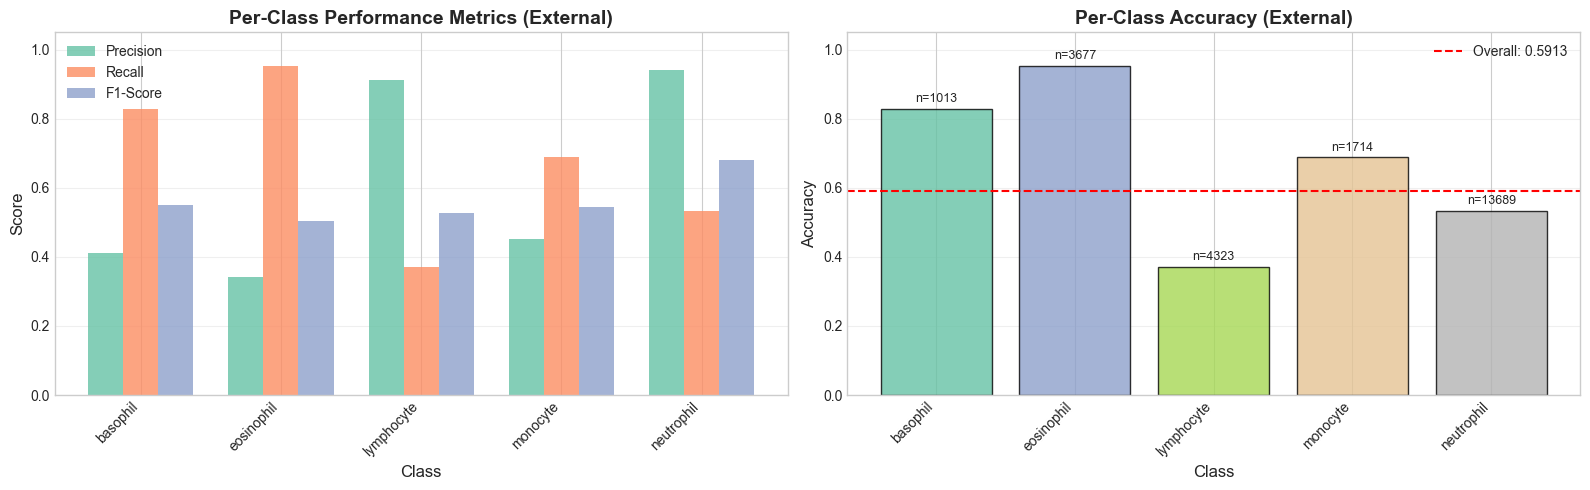

In [14]:
# Visualize per-class performance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Precision, Recall, F1-Score
x = np.arange(len(class_names))
width = 0.25

axes[0].bar(x - width, metrics_df['Precision'], width, label='Precision', alpha=0.8)
axes[0].bar(x, metrics_df['Recall'], width, label='Recall', alpha=0.8)
axes[0].bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Per-Class Performance Metrics (External)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1.05])
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Accuracy per class with support as bar width
colors = plt.cm.Set2(np.linspace(0, 1, len(class_names)))
bars = axes[1].bar(class_names, metrics_df['Accuracy'], color=colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Per-Class Accuracy (External)', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_ylim([0, 1.05])
axes[1].axhline(y=ext_accuracy.item(), color='r', linestyle='--', 
                label=f'Overall: {ext_accuracy:.4f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add sample counts on bars
for bar, count in zip(bars, metrics_df['Support']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'n={int(count)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/figures/per_class_metrics_external.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Performance by Source Dataset

In [15]:
# Add predictions to dataframe for analysis
external_df['predicted'] = [class_names[i] for i in ext_pred_classes.numpy()]
external_df['correct'] = external_df['label'] == external_df['predicted']
external_df['confidence'] = ext_confidences.numpy()

# Performance by source dataset
print("Performance by Source Dataset:")
print("="*70)

source_metrics = []
for source in external_df['source_dataset'].unique():
    source_data = external_df[external_df['source_dataset'] == source]
    acc = source_data['correct'].mean()
    source_metrics.append({
        'Source': source,
        'Total': len(source_data),
        'Correct': source_data['correct'].sum(),
        'Incorrect': (~source_data['correct']).sum(),
        'Accuracy': acc,
        'Avg Confidence': source_data['confidence'].mean()
    })

source_df = pd.DataFrame(source_metrics)
print(source_df.to_string(index=False))

Performance by Source Dataset:
     Source  Total  Correct  Incorrect  Accuracy  Avg Confidence
    dataset  16632     6725       9907  0.404341        0.759018
pbc_dataset   7784     7711         73  0.990622        0.992827


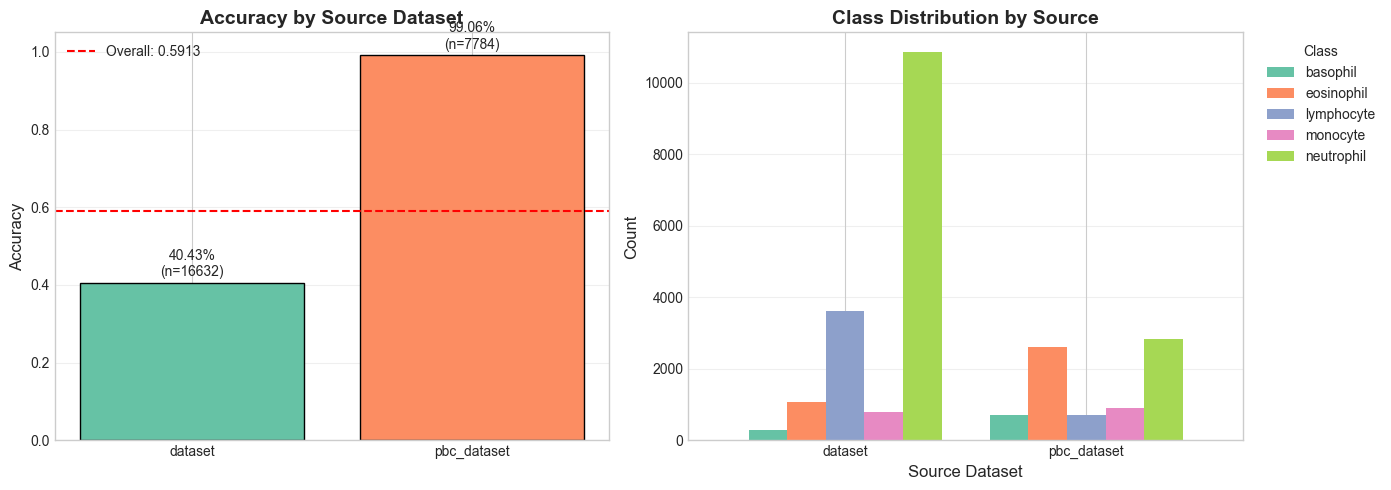

In [16]:
# Visualize performance by source
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by source
colors = ['#66c2a5', '#fc8d62']
bars = axes[0].bar(source_df['Source'], source_df['Accuracy'], color=colors, edgecolor='black')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy by Source Dataset', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1.05])
axes[0].axhline(y=ext_accuracy.item(), color='r', linestyle='--', 
                label=f'Overall: {ext_accuracy:.4f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add values on bars
for bar, acc, n in zip(bars, source_df['Accuracy'], source_df['Total']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{acc:.2%}\n(n={n})', ha='center', va='bottom', fontsize=10)

# Plot 2: Class distribution by source
source_class_counts = external_df.groupby(['source_dataset', 'label']).size().unstack(fill_value=0)
source_class_counts.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_xlabel('Source Dataset', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Class Distribution by Source', fontsize=14, fontweight='bold')
axes[1].legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/performance_by_source.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [17]:
# Analyze misclassifications
errors_df = external_df[~external_df['correct']].copy()

print(f"Total misclassifications: {len(errors_df)} out of {len(external_df)}")
print(f"Error rate: {len(errors_df)/len(external_df)*100:.2f}%")
print("\nMisclassifications by true class:")
print(errors_df['label'].value_counts().sort_index())

print("\nMisclassifications by predicted class:")
print(errors_df['predicted'].value_counts().sort_index())

Total misclassifications: 9980 out of 24416
Error rate: 40.87%

Misclassifications by true class:
label
basophil       174
eosinophil     171
lymphocyte    2719
monocyte       534
neutrophil    6382
Name: count, dtype: int64

Misclassifications by predicted class:
predicted
basophil      1206
eosinophil    6732
lymphocyte     157
monocyte      1435
neutrophil     450
Name: count, dtype: int64


In [18]:
# Error confusion: what gets confused with what?
print("\nMost common misclassification patterns:")
print("="*70)

error_patterns = errors_df.groupby(['label', 'predicted']).size().reset_index(name='count')
error_patterns = error_patterns.sort_values('count', ascending=False).head(10)

for _, row in error_patterns.iterrows():
    print(f"  {row['label']:12s} → {row['predicted']:12s}: {row['count']:5d} errors")


Most common misclassification patterns:
  neutrophil   → eosinophil  :  4501 errors
  lymphocyte   → eosinophil  :  1664 errors
  neutrophil   → monocyte    :   879 errors
  neutrophil   → basophil    :   868 errors
  monocyte     → eosinophil  :   432 errors
  lymphocyte   → monocyte    :   419 errors
  lymphocyte   → neutrophil  :   361 errors
  lymphocyte   → basophil    :   275 errors
  basophil     → eosinophil  :   135 errors
  neutrophil   → lymphocyte  :   134 errors


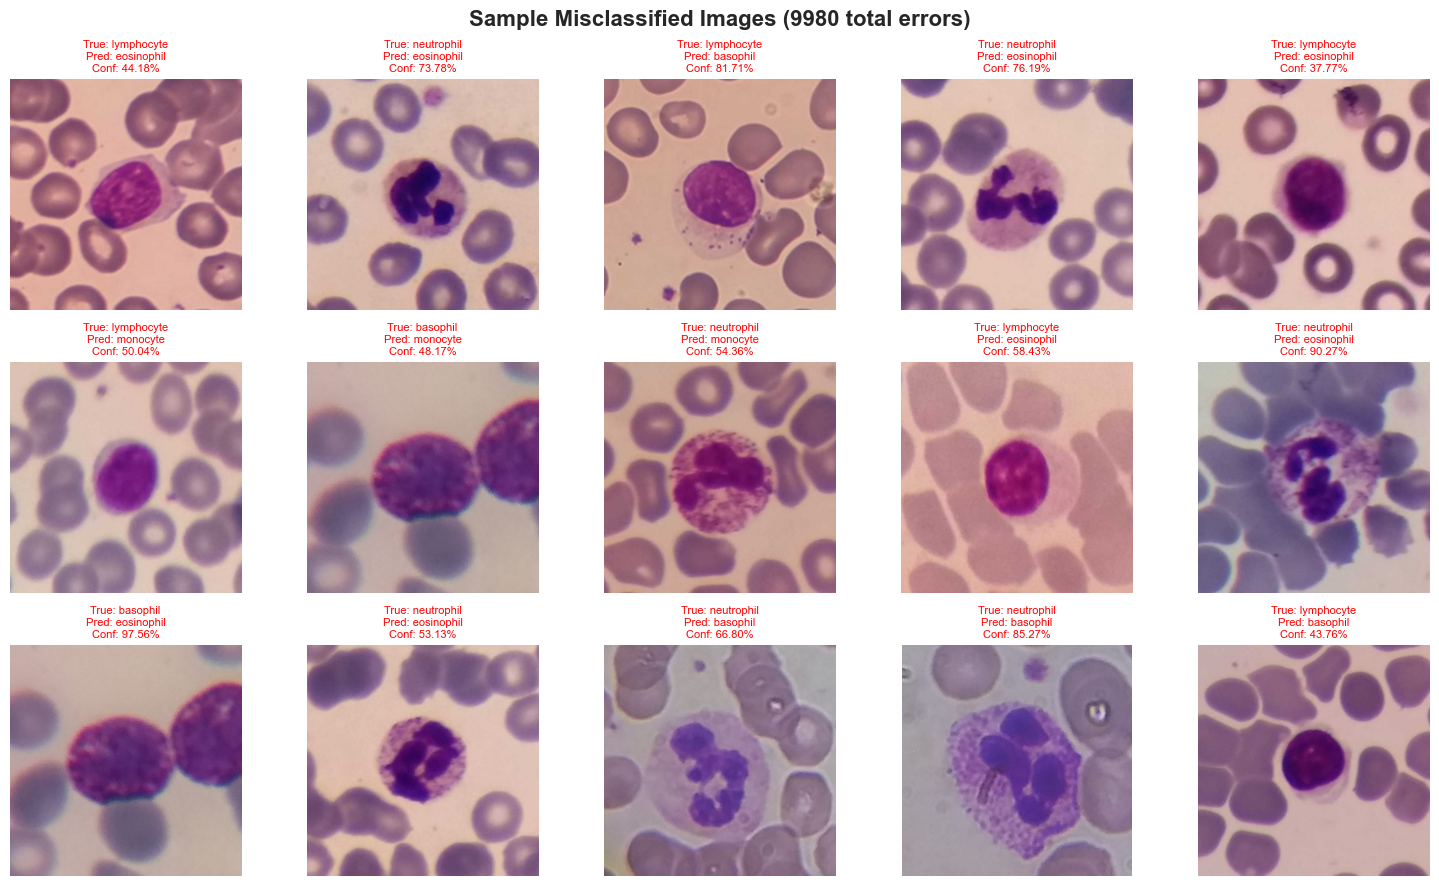

In [19]:
# Visualize some misclassified examples
n_show = min(15, len(errors_df))
sample_errors = errors_df.sample(n=n_show, random_state=42)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle(f'Sample Misclassified Images ({len(errors_df)} total errors)', 
             fontsize=16, fontweight='bold')

for idx, (_, row) in enumerate(sample_errors.iterrows()):
    if idx >= 15:
        break
    ax = axes[idx // 5, idx % 5]
    
    try:
        img = Image.open(row['filepath'])
        ax.imshow(img)
    except:
        ax.text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center')
    
    ax.set_title(f"True: {row['label']}\nPred: {row['predicted']}\nConf: {row['confidence']:.2%}", 
                 fontsize=8, color='red')
    ax.axis('off')

# Hide empty subplots
for idx in range(n_show, 15):
    axes[idx // 5, idx % 5].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/misclassified_external.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Confidence Analysis

/var/folders/wg/l913cp994dgc0lk1jcm9l7w40000gn/T/ipykernel_13980/1882897775.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(class_conf.index, rotation=45, ha='right')


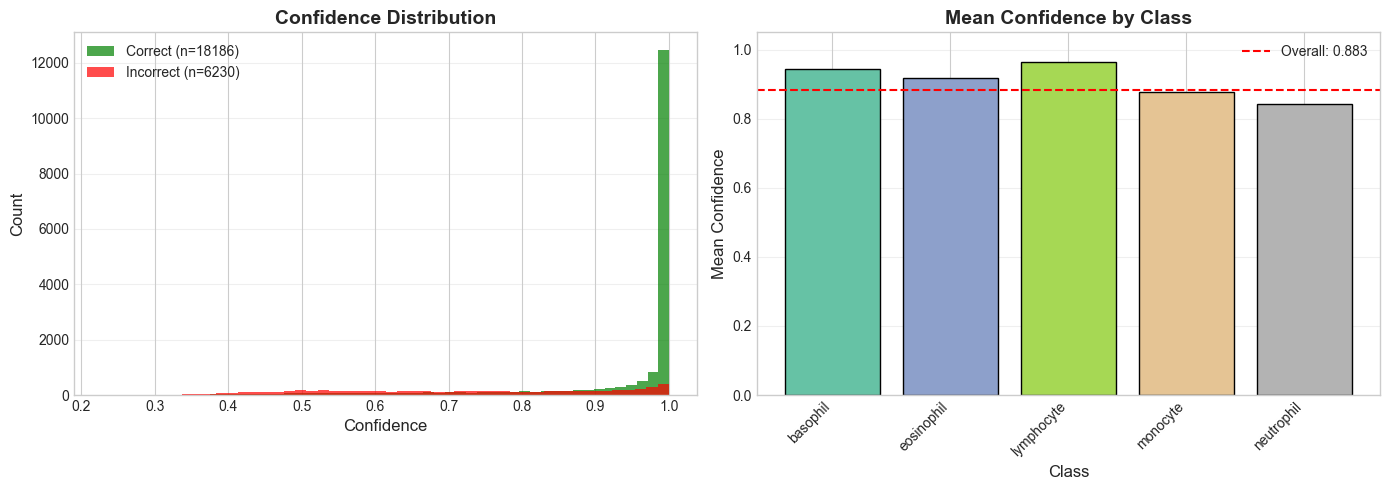


Confidence Statistics:
  Correct predictions: mean=0.9384, std=0.1304
  Incorrect predictions: mean=0.7196, std=0.1913


In [18]:
# Confidence distribution for correct vs incorrect predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram of confidence scores
correct_conf = external_df[external_df['correct']]['confidence']
incorrect_conf = external_df[~external_df['correct']]['confidence']

axes[0].hist(correct_conf, bins=50, alpha=0.7, label=f'Correct (n={len(correct_conf)})', color='green')
axes[0].hist(incorrect_conf, bins=50, alpha=0.7, label=f'Incorrect (n={len(incorrect_conf)})', color='red')
axes[0].set_xlabel('Confidence', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Confidence by class
class_conf = external_df.groupby('label')['confidence'].mean().sort_index()
bars = axes[1].bar(class_conf.index, class_conf.values, color=plt.cm.Set2(np.linspace(0, 1, 5)), edgecolor='black')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Mean Confidence', fontsize=12)
axes[1].set_title('Mean Confidence by Class', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(class_conf.index, rotation=45, ha='right')
axes[1].set_ylim([0, 1.05])
axes[1].axhline(y=external_df['confidence'].mean(), color='r', linestyle='--', 
                label=f'Overall: {external_df["confidence"].mean():.3f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/confidence_analysis_external.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Correct predictions: mean={correct_conf.mean():.4f}, std={correct_conf.std():.4f}")
print(f"  Incorrect predictions: mean={incorrect_conf.mean():.4f}, std={incorrect_conf.std():.4f}")

## 10. Comparison with Test Set

In [19]:
# Load test set results for comparison
split_df = pd.read_csv('../outputs/data_split.csv')
test_df = split_df[split_df['split'] == 'test'].reset_index(drop=True)

# Get test predictions
test_dl = learn.dls.test_dl(test_df['filepath'].tolist())
test_preds, _ = learn.get_preds(dl=test_dl)
test_pred_classes = test_preds.argmax(dim=1)
test_targets = torch.tensor([label_to_idx[label] for label in test_df['label']])
test_accuracy = (test_pred_classes == test_targets).float().mean()

print(f"Test set accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Test set accuracy: 0.9733 (97.33%)


In [20]:
# Comparison table
comparison_data = {
    'Dataset': ['Test Set', 'External (Full)', 'External (dataset/)', 'External (PBC)'],
    'Size': [
        len(test_df), 
        len(external_df),
        len(external_df[external_df['source_dataset'] == 'dataset']),
        len(external_df[external_df['source_dataset'] == 'pbc_dataset'])
    ],
    'Accuracy': [
        test_accuracy.item(),
        ext_accuracy.item(),
        external_df[external_df['source_dataset'] == 'dataset']['correct'].mean(),
        external_df[external_df['source_dataset'] == 'pbc_dataset']['correct'].mean()
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Error Rate'] = 1 - comparison_df['Accuracy']

print("\nPerformance Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))


Performance Comparison:
            Dataset  Size  Accuracy  Error Rate
           Test Set   375  0.973333    0.026667
    External (Full) 24416  0.744839    0.255161
External (dataset/) 16632  0.634139    0.365861
     External (PBC)  7784  0.981372    0.018628


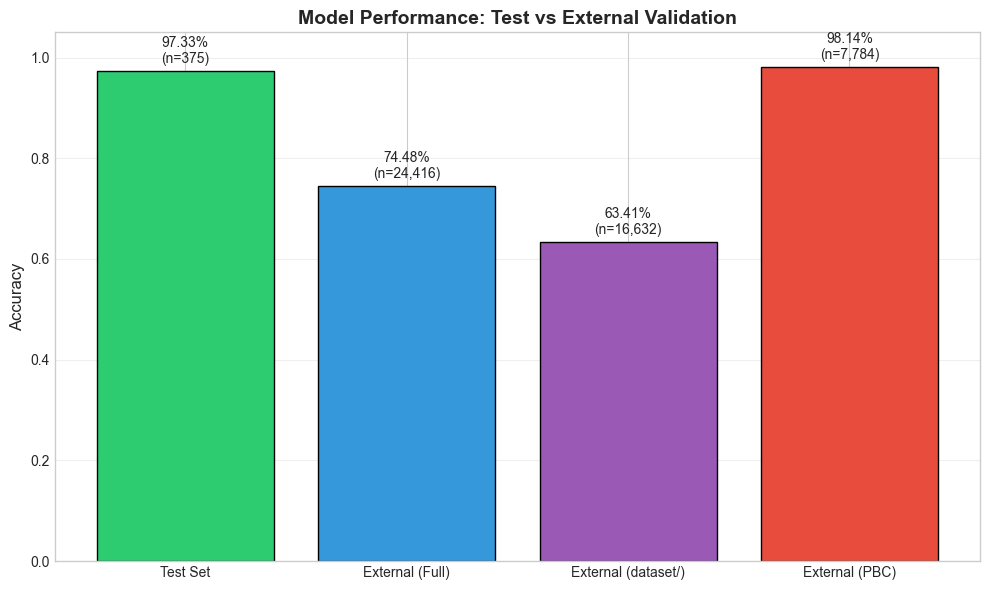

In [21]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
bars = ax.bar(comparison_df['Dataset'], comparison_df['Accuracy'], color=colors, edgecolor='black')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Performance: Test vs External Validation', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

# Add values on bars
for bar, acc, n in zip(bars, comparison_df['Accuracy'], comparison_df['Size']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{acc:.2%}\n(n={n:,})', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/figures/test_vs_external_full.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Final Summary

In [22]:
print("="*70)
print("EXTENDED EXTERNAL VALIDATION - FINAL SUMMARY")
print("="*70)

print(f"\nModel: {model_path}")
print(f"Classes: {class_names}")

print(f"\n{'Dataset':<25} {'Size':>10} {'Accuracy':>12} {'Errors':>10}")
print("-"*60)
print(f"{'Test Set':<25} {len(test_df):>10,} {test_accuracy.item():>11.2%} {int((1-test_accuracy.item())*len(test_df)):>10,}")
print(f"{'External (Full)':<25} {len(external_df):>10,} {ext_accuracy.item():>11.2%} {len(errors_df):>10,}")

print(f"\nPer-Class Performance (External):")
print("-"*60)
for _, row in metrics_df.iterrows():
    print(f"  {row['Class']:<12} Acc: {row['Accuracy']:.2%}  F1: {row['F1-Score']:.4f}  (n={int(row['Support']):,})")

print(f"\nGeneralization Gap: {abs(test_accuracy.item() - ext_accuracy.item())*100:.2f}%")

if ext_accuracy >= 0.92:
    print(f"\n✓ TARGET ACHIEVED: External accuracy ≥ 92%")
else:
    print(f"\n✗ Target not met: External accuracy < 92%")

print(f"\nGenerated Figures:")
print(f"  ✓ confusion_matrix_external_full.png")
print(f"  ✓ confusion_matrix_external_normalized.png")
print(f"  ✓ per_class_metrics_external.png")
print(f"  ✓ performance_by_source.png")
print(f"  ✓ misclassified_external.png")
print(f"  ✓ confidence_analysis_external.png")
print(f"  ✓ test_vs_external_full.png")

print("\n" + "="*70)
print("✓ Extended external validation complete!")
print("="*70)

EXTENDED EXTERNAL VALIDATION - FINAL SUMMARY

Model: ../outputs/model.pkl
Classes: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

Dataset                         Size     Accuracy     Errors
------------------------------------------------------------
Test Set                         375      97.33%          9
External (Full)               24,416      74.48%      6,230

Per-Class Performance (External):
------------------------------------------------------------
  basophil     Acc: 74.14%  F1: 0.7956  (n=1,013)
  eosinophil   Acc: 83.11%  F1: 0.7497  (n=3,677)
  lymphocyte   Acc: 95.26%  F1: 0.7845  (n=4,323)
  monocyte     Acc: 75.32%  F1: 0.4656  (n=1,714)
  neutrophil   Acc: 65.53%  F1: 0.7886  (n=13,689)

Generalization Gap: 22.85%

✗ Target not met: External accuracy < 92%

Generated Figures:
  ✓ confusion_matrix_external_full.png
  ✓ confusion_matrix_external_normalized.png
  ✓ per_class_metrics_external.png
  ✓ performance_by_source.png
  ✓ misclassified_ex

In [23]:
# Save detailed results to CSV
results_path = '../outputs/external_validation_results.csv'
external_df.to_csv(results_path, index=False)
print(f"\n✓ Detailed results saved to: {results_path}")


✓ Detailed results saved to: ../outputs/external_validation_results.csv
